In [1]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
from util.load import DataLoader
from util.backtest import Backtest
from util.plot import (
    create_pairwise_scatter_plot,
    create_correlation_matrix,
    plot_backtest_results,
)

In [2]:
dataloader = DataLoader(data_dir="../data")
ticker = "kxhighny"
max_days = 100
df = dataloader.load_consolidated_daily_data(
    ticker, max_days=max_days, type_="polysignal"
)
df.drop(columns=["time", "ticker", "trade_id"]).head()

Loading kxhighny for 2025-03-25: 100%|██████████| 34/34 [00:00<00:00, 182.62it/s]


,time_to_strike,day_forecast_strike_dev,current_forecast_strike_dev,day_current_forecast_dev,day_wind_gusts_max,day_wind_speed_max,day_cloud_cover_max,day_cloud_cover_min,day_sunshine_duration,hour_wind_gusts,...,yes_price_sentiment_60,count_sentiment_60,yes_price_trend_60,count_agg_120,yes_price_vol_120,count_vol_120,taker_side_sentiment_120,yes_price_sentiment_120,count_sentiment_120,yes_price_trend_120
0,86378.686,1.3,-12.1,13.4,51.8,27.5,99,0,41428.27,18.4,...,43.333,100.733,-4,1511,2.637,99.877,1.0,43.333,100.733,-4
1,86378.686,1.3,-12.1,13.4,51.8,27.5,99,0,41428.27,18.4,...,43.333,100.733,-4,1511,2.637,99.877,1.0,43.333,100.733,-4
2,86378.686,1.3,-12.1,13.4,51.8,27.5,99,0,41428.27,18.4,...,43.333,100.733,-4,1511,2.637,99.877,1.0,43.333,100.733,-4
3,86378.686,1.3,-12.1,13.4,51.8,27.5,99,0,41428.27,18.4,...,43.333,100.733,-4,1511,2.637,99.877,1.0,43.333,100.733,-4
4,86378.686,1.3,-12.1,13.4,51.8,27.5,99,0,41428.27,18.4,...,43.333,100.733,-4,1511,2.637,99.877,1.0,43.333,100.733,-4


In [3]:
print(np.mean(df[df["taker_side"] == 1]["result"]))
print(np.mean(df[df["taker_side"] == 0]["result"]))

-2.8408000767459707
-0.8561986321052935


In [6]:
np.mean(df['outcome'])

np.float64(0.35414542317044473)

In [4]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import VotingClassifier


class Model(object):
    def __init__(
        self,
        output_metric: str = "result",
        features: list[str] = None,
        outlier_threshold: float = 0.00,
    ):
        self.output_metric = output_metric
        self.features = features
        self.outlier_threshold = outlier_threshold
        self.pipeline = Pipeline(
            [
                ("robust_scaler", RobustScaler(unit_variance=True)),
                # ("quantile_transformer", QuantileTransformer(n_quantiles=100, output_distribution="normal")),
                (
                    "voting",
                    VotingClassifier(
                        estimators=[
                            (
                                "gb",
                                GradientBoostingClassifier(
                                    n_estimators=50,
                                    learning_rate=0.01,
                                    max_depth=4,
                                    subsample=0.5,
                                    min_samples_split=50,
                                    random_state=42,
                                ),
                            ),
                            (
                                "rf",
                                RandomForestClassifier(
                                    n_estimators=50, max_depth=4, random_state=42
                                ),
                            ),
                            ("logistic", LogisticRegression()),
                            ("knn", KNeighborsClassifier(n_neighbors=10)),
                        ],
                        n_jobs=-1,
                    ),
                ),
            ]
        )

    def __call__(
        self, train_data: pd.DataFrame, input_data: pd.DataFrame
    ) -> pd.DataFrame:
        if self.features is None:
            self.features = [
                f
                for f in train_data.columns.tolist()
                if (
                    f
                    not in ["time", "result", "impact", "ticker", "trade_id", "outcome"]
                )
                and (not f[-1].isdigit())
            ]
            # print(self.features)
        self.pipeline.fit(train_data[self.features], train_data[self.output_metric])
        input_predictions = self.pipeline.predict(input_data[self.features])
        train_predictions = self.pipeline.predict(train_data[self.features])
        return train_predictions, input_predictions

In [8]:
# plt.hist(df['outcome'])

# plt.show()
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(
    df, test_size=0.2, random_state=42, shuffle=False
)

model = Model()
train_predictions, test_predictions = model(train_data, test_data)

print(accuracy_score(test_data["outcome"], test_predictions))

/opt/anaconda3/envs/quant/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.0


<Axes: xlabel='date'>

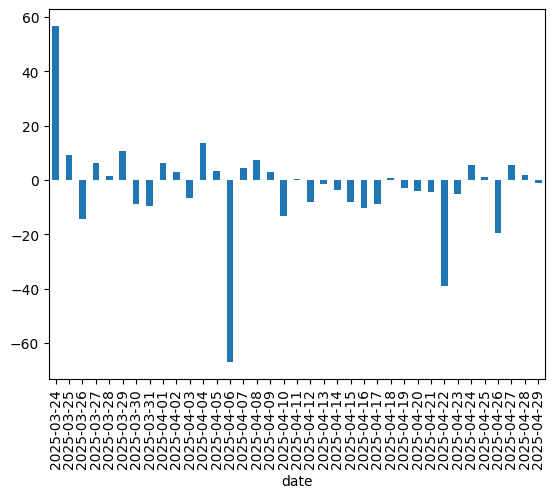

In [5]:
df["date"] = pd.to_datetime(df["time"]).dt.date
df[df["taker_side"] == 1].groupby("date")["result"].mean().plot(
    x="date", y="result", kind="bar"
)